In [1]:
import math
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from tabulate import tabulate

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

# The following imports NEED to be in the exact order
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from validation.tokeneconomy.baseline import economyconfig
from validation.tokeneconomy.baseline.economyconfig import experiment

from validation.plot_functions import *

exec_mode = ExecutionMode()

In [2]:
configs = experiment.configs

single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
run1 = Executor(exec_context=single_proc_ctx, configs=[configs[0]])
run1_raw_result, raw_tensor_field, _ = run1.execute()
raw_df = pd.DataFrame(run1_raw_result)
df = raw_df[raw_df['substep']==5]


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1040, 1, 1, 22)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1040, 1, 1, 22)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec
Execution Mode: single_threaded


/Users/danlessa/anaconda3/lib/python3.11/site-packages/cadCAD/utils/__init__.py:143: FutureWarning: The use of a dictionary to describe Partial State Update Blocks will be deprecated. Use a list instead.
  warnings.warn(


Flattening results:   0%|          | 0/5201 [00:00<?, ?it/s]

Total execution time: 0.71s


In [3]:
pd.options.mode.chained_assignment = None
df['lambda_S_factor'] = df['R'] / df['R_prev']
df['lambda_D_factor'] = df['P_prev'] / df['P']

# factors going into V
# V(t) ~ (P(t) * Q(t) + B(t)) / (C(t) * Q(t))
df['CQ'] = df['C'] * df['Q']
df['PQ_K'] = df['P'] * df['Q']
df['PQplusB_K'] = df['P'] * df['Q'] + df['B']
df['PQ_FIAT'] = df['P'] * df['Q'] * df['K']
df['PQplusB_FIAT'] = (df['P'] * df['Q'] + df['B']) * df['K']
df['PoverC'] = df['P'] / df['C']
df['BoverCQ'] = df['B'] / df['CQ']
df['P_FIAT'] = df['P'] * df['K']
df['V_inverse'] = 1.0 / df['V']
df['log_K'] = np.log(df['K'])
df['log_P_FIAT'] = np.log(df['P_FIAT'])
# df['delta_KPI'] = df['KPI'] - df['KPI_prev']
df['PprevOverP'] = df['P_prev'] / df['P']
df['QoverQprev'] = df['Q'] / df['Q_prev']
df['QoverQ0'] = df['Q'] / df['Q'].iloc[0]

# supply - demand
df['SdiffD'] = df['S'] - df['D']
df['DdiffS'] = df['D'] - df['S']

In [4]:
NUMERIC_COLS = ((df.dtypes == float) | (df.dtypes == int))
num_df = df.loc[:, NUMERIC_COLS]

mean_df = num_df.groupby(aggregate_dimension).mean().reset_index()
median_df = num_df.groupby(aggregate_dimension).median().reset_index()
std_df = num_df.groupby(aggregate_dimension).std().reset_index()
min_df = num_df.groupby(aggregate_dimension).min().reset_index()
num_df.rename(columns={'weeks': "timestep"}, inplace=True)

### Simulation - step decay block rewards

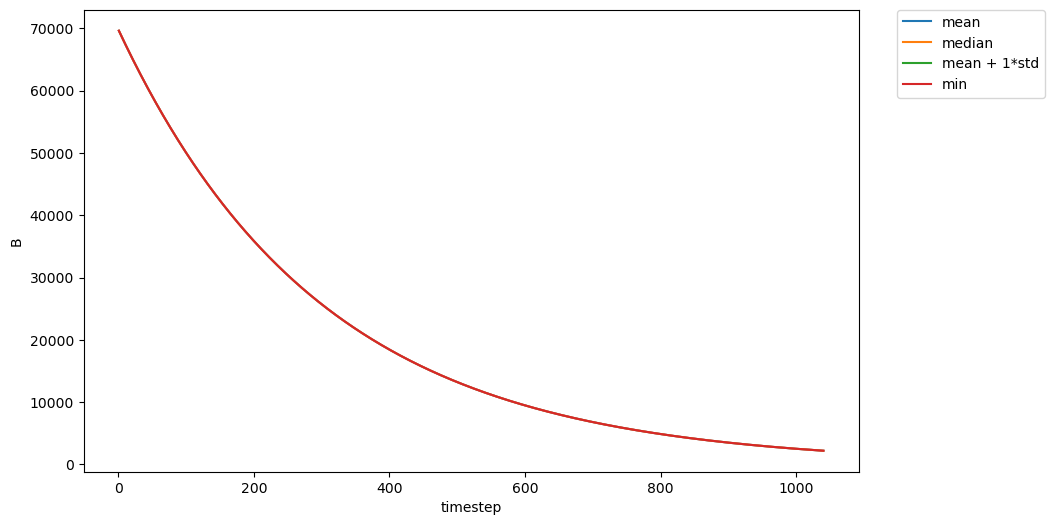

In [5]:
dist_plot(num_df, 'timestep', 'B')

#### K - secondary market price of token

<Figure size 640x480 with 0 Axes>

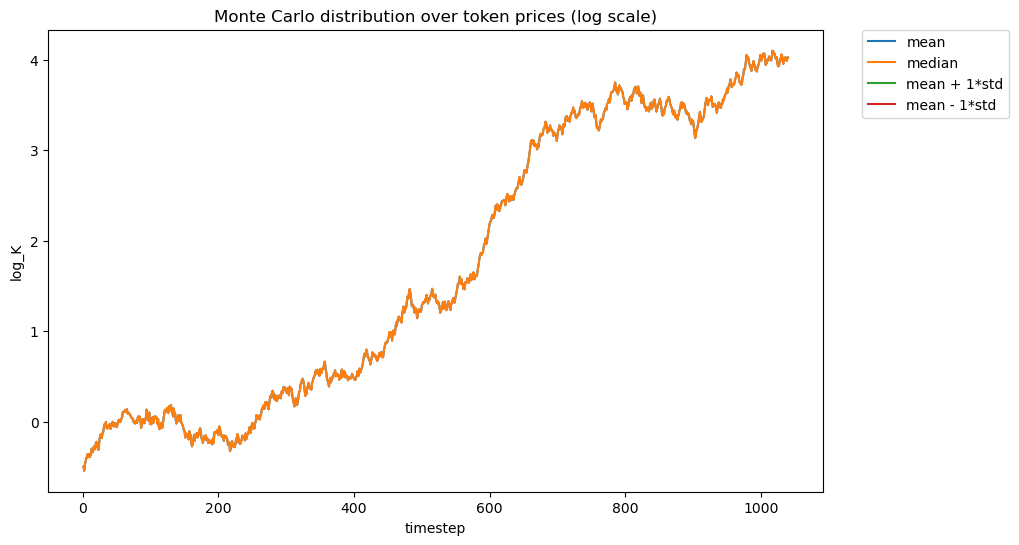

In [6]:
plt.figure()
dist_plot(num_df, 'timestep', 'log_K', suppMin=True)
title_text = 'Monte Carlo distribution over token prices (log scale)'
plt.title(title_text)
plt.show()

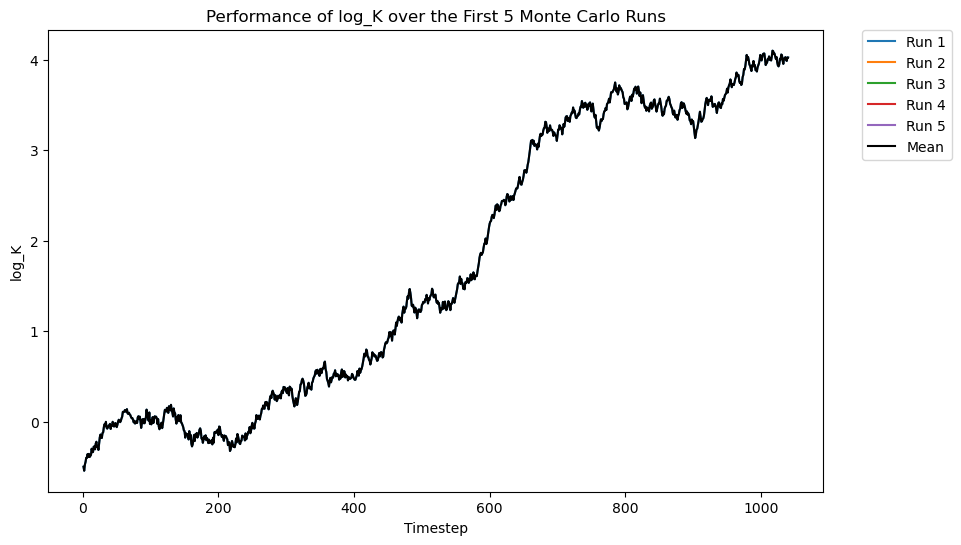

In [7]:
first_five_plot(num_df, 'log_K')

#### Q - service transacted on the platform

/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_28451/2437245007.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(normalized_Q)


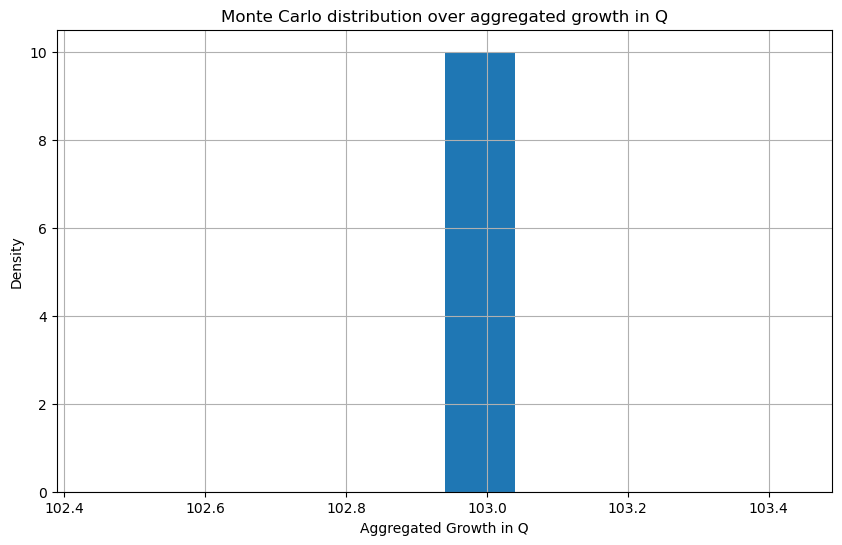

In [8]:
terminal_Q = num_df.groupby('run').last().reset_index()['Q']
initial_Q = num_df.groupby('run').first().reset_index()['Q']
normalized_Q = terminal_Q / initial_Q
plt.figure(figsize=(10, 6))
normalized_Q.hist(density=True)
sns.kdeplot(normalized_Q)
plt.xlabel('Aggregated Growth in Q')
title_text = 'Monte Carlo distribution over aggregated growth in Q'
plt.title(title_text)
plt.show()